# Airport weekly penalty for arrivals and departures delays 

In this notebook we compute a weekly "**penalty**" score for each airport that depends on both the its incoming and outgoing flights. The score adds `0.5` for each incoming flight that is more than _15 minutes_ late, and `1` for
each outgoing flight that is more than _15 minutes_ late.

Formally speaking, let $w = \{1, 2, \ldots, 52 \}$ be the _week number_ in a year $y$ and $f$ be a flight _leaving from_ or _arriving to_ $airport$ on week $w$ of year $year$. Then we compute the weekly penalties as the following:

$$ ArrivalPenalty(f, y, w) = \begin{cases} 0.5 & \mbox{if } ArrDelay(f) > 15\mbox{ seconds}\\
                                           0 & \mbox{otherwise}
                                 \end{cases}
$$

$$ DeparturePenalty(f, y, w) = \begin{cases} 1 & \mbox{if } DepDelay(f) > 15\mbox{ seconds}\\
                                             0 & \mbox{otherwise}
                                   \end{cases}
$$

$$ WeeklyPenalty(airport, y, w) = \sum_{f} ArrivalPenalty(f, y, w) + DeparturePenalty(f, y, w) \\
$$

#### Execution mode

If development mode is turned on, all the calculations will be performed on a reduced instance of the data set.

This allows to *save computation time* while developing.

In [1]:
# development mode
# False when performing real analytics
DEV = False

### threads to be used to run spark worker nodes locally
spark_local_threads = 4

# default transformed dataset path
transformed_dataset_path = '../dataset/04_cache_airport_weekly_penalty.parquet'
missings_dataframe_path = '../dataset/04_cache_airport_weekly_penalty_missings.pkl'

#### Find and import Apache Spark on current machine

In [2]:
import findspark
findspark.init()

In [3]:
# imports
import pickle

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pathlib import Path

from missing_values_utils import *

#### Create a new session

In [4]:
# Build a Spark SQL Session for DataFrames
master = 'local[{}]'.format(spark_local_threads)
appName = 'Airport weekly penalty'
spark = SparkSession  \
    .builder          \
    .appName(appName) \
    .master(master)   \
    .getOrCreate()

### Load data

Try to load the optimized parquet format data set. If parquet data set is not found, load full compressed data sets, reduce and save them.

In [5]:
from preprocessing_utils import *

if DEV:
    # DEV preprocessing
    perform_DEV_dataset_preprocessing(spark)
else:
    # Production preprocessing
    perform_dataset_preprocessing(spark)

Starting preprocessing of ../dataset/*.csv.bz2
Preprocessing NOT performed.
Preprocessed dataset already exists: ../dataset/preprocessed_dataset.parquet



In [6]:
# Load the parquet dataset
if DEV:
    # Load DEV dataset
    df = load_DEV_preprocessed_dataset(spark)
else:
    # Load production dataset
    df = load_preprocessed_dataset(spark)

Peprocessed dataset loaded.
../dataset/preprocessed_dataset.parquet


### Attributes selection

In [7]:
# Keep only the dimensions we need
df = df.select('Year', 'Month', 'DayofMonth', 'ArrTime', 'DepTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest')
# Explore the data
#df.printSchema()

### Missing values exploration and exclusion

In [8]:
df.count()

91469371

In [9]:
df, df_missing = get_df_missing_and_drop_all_null(df, False, missings_dataframe_path)

Years examined:
 [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]

Missing values inspection:
0  null values in:  Year
0  null values in:  Month
0  null values in:  DayofMonth
2148475  null values in:  ArrTime
1949479  null values in:  DepTime
2151526  null values in:  ArrDelay
1949479  null values in:  DepDelay
0  null values in:  Origin
0  null values in:  Dest


        Count  MissingsCount  MissingsPercentage
1994  5180048          78846            0.015221
1995  5327435         102397            0.019221
1996  5351983         142657            0.026655
1997  5411843         109844            0.020297
1998  5384721         157670            0.029281
1999  5527884         167866            0.030367
2000  5683047         201744            0.035499
2001  5967780         244107            0.040904
2002  5271359          73499            0.013943
2003  6488540         112851            0.017392
2004  7129270         141541            0.019854
20

In [10]:
df.count()

89317845

In [11]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)



In [12]:
df = df.select('Year', 'Month', 'DayofMonth', 'ArrDelay', 'DepDelay', 'Origin', 'Dest')
# Explore the data
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)



In [13]:
# cast delays to integer
df = df.withColumn('ArrDelay', df['ArrDelay'].cast(IntegerType()))
df = df.withColumn('DepDelay', df['DepDelay'].cast(IntegerType()))

In [14]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)



### Compute weekly-penalty analytics

In [15]:
# compute the week number

# function to get the week number
def week_year(year, month, day):
    import datetime
    date = datetime.datetime(year, month, day) 
    return date.isocalendar()[1]
week_year = F.udf(week_year, IntegerType())

df = df.withColumn('WeekOfYear', week_year(df['Year'], df['Month'], df['DayofMonth']))

In [16]:
# Flights that are more than 15 minutes late
left_late = df.filter(df['DepDelay'] > 15)
arrived_late = df.filter(df['ArrDelay'] > 15)

# Number of times per week an airport had a departure or an arrival more than 15 minutes late
incoming_late = arrived_late.groupBy(['Year', 'WeekOfYear', arrived_late['Dest'].alias('Airport')]).count()
outgoing_late = left_late.groupBy(['Year', 'WeekOfYear', left_late['Origin'].alias('Airport')]).count()

#incoming_late.show(10)
#outgoing_late.show(10)

In [17]:
# Penalties on arrivals and departures
incoming_factor = 0.5
outgoing_factor = 1.0

incoming_penalty = incoming_late.select('Year', 'WeekOfYear', 'Airport', (incoming_late['count'] * incoming_factor).alias('Penalty'))
outgoing_penalty = outgoing_late.select('Year', 'WeekOfYear', 'Airport', (outgoing_late['count'] * outgoing_factor).alias('Penalty'))

#incoming_penalty.show(10)
#outgoing_penalty.show(10)

In [18]:
# Sum up the penalties
penalties = incoming_penalty.unionAll(outgoing_penalty)               \
                            .groupBy('Year', 'WeekOfYear', 'Airport') \
                            .sum('Penalty')                           \
                            .withColumnRenamed('sum(Penalty)', 'WeeklyPenalty')

# penalties.show(10)

In [19]:
# Store output Dataframe (or load it if already existing)
if not Path(transformed_dataset_path).is_dir():
    penalties.write.mode('overwrite').save(transformed_dataset_path, format='parquet')

penalties = spark.read.load(transformed_dataset_path)

In [20]:
# Output a list of tuples of schema:
# ('Year', 'WeekYear', 'Airport', 'WeeklyPenalty')
penalty_data = penalties.rdd.map(tuple).collect()
print(penalty_data[:10])

# Airports
airports = penalties.select('Airport').distinct().orderBy('Airport').rdd.map(lambda x : x[0]).collect()

[(2007, 2, 'DTW', 784.5), (2007, 3, 'TUL', 209.0), (2007, 2, 'PSP', 96.0), (2007, 3, 'GRB', 67.0), (2007, 2, 'GTF', 12.5), (2007, 5, 'MLU', 27.0), (2007, 3, 'SJT', 13.5), (2007, 5, 'FAI', 16.0), (2007, 7, 'DAY', 148.0), (2007, 8, 'DAB', 30.0)]


##### Data visualization functions

Scroll down to see the charts

In [21]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Weekly penalties over a year analytics 

In [22]:
def get_pd_dataframe(airport, years, df):
    rows = df.filter(F.col('Airport') == airport) \
             .filter(F.col('Year').isin(*years)) \
             .select('Year', 'WeekOfYear', 'WeeklyPenalty') \
             .orderBy('Year', 'WeekOfYear') \
             .collect()
    
    nb_years = len(years)
    nb_weeks = 52
    data = np.zeros((nb_weeks, nb_years))
    for row in rows:
        year = row[0] - years[0]
        week = row[1] - 1
        pen = row[2]

        if week > 51: continue
        data[week, year] = pen
    columns = [str(y) for y in years]
    indices = range(1, 53)
    res = pd.DataFrame(data=data, columns=columns, index=indices)
    return res

def plot_penalty_time_series(airport, years, df, ax):
    df = get_pd_dataframe(airport, years, df)
    title = '{} Airport - Weekly penalty'.format(airport)
    if df.empty:
        print('No data for airport {}'.format(airport))
    else:
        df.plot(title=title, grid=True, xticks=range(0, 53, 4), ax=ax)

#### Average penalty in a year

In [23]:
def get_average_df(airport, years, df):
    rows = df.filter(F.col('Airport') == airport) \
             .filter(F.col('Year').isin(*years)) \
             .groupBy('Year') \
             .avg('WeeklyPenalty') \
             .withColumnRenamed('avg(WeeklyPenalty)', 'AveragePenalty') \
             .select('Year', 'AveragePenalty') \
             .collect()
    
    nb_years = len(years)
    data = np.zeros(nb_years)
    for row in rows:
        year = row[0] - years[0]
        avg_pen = row[1]
        data[year] = avg_pen 
    res = pd.DataFrame({airport: data}, index=years)
    return res

def plot_average_penalty(airport, years, df, ax):
    df = get_average_df(airport, years, df)
    title = '{} Airport - Average Penalties'.format(airport)
    if df.empty:
        print('No data for airport {}'.format(airport))
    else:
        df.plot.bar(y=airport, title=title, rot=90, ax=ax, legend=False)

In [24]:
def ui_callback(airport, years, df):
    plt.figure(figsize=(15,12))
    plt.clf()
    ax = plt.subplot(211)
    plot_penalty_time_series(airport, range(years[0], years[1] + 1), df, ax)
    
    ax = plt.subplot(212)
    plot_average_penalty(airport, range(years[0], years[1] + 1), df, ax)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.show()

# Years selection range
years = range(1994, 2009)
years = [(str(y), y) for y in years]
years_w = widgets.SelectionRangeSlider(options=years,
                                       index=(0, 2),
                                       description='Years',
                                       continuous_update=False)
# Airport selection menu
airports_w = widgets.Dropdown(options=airports,
                              value=airports[0],
                              description='Airport')

out = widgets.interactive_output(ui_callback, {'airport': airports_w, 'years': years_w, 'df': widgets.fixed(penalties)})
ui = widgets.HBox([airports_w, years_w])

## Data Visualization

Analytics for airports weekly penalty are reported below.

### Missing values and valid data

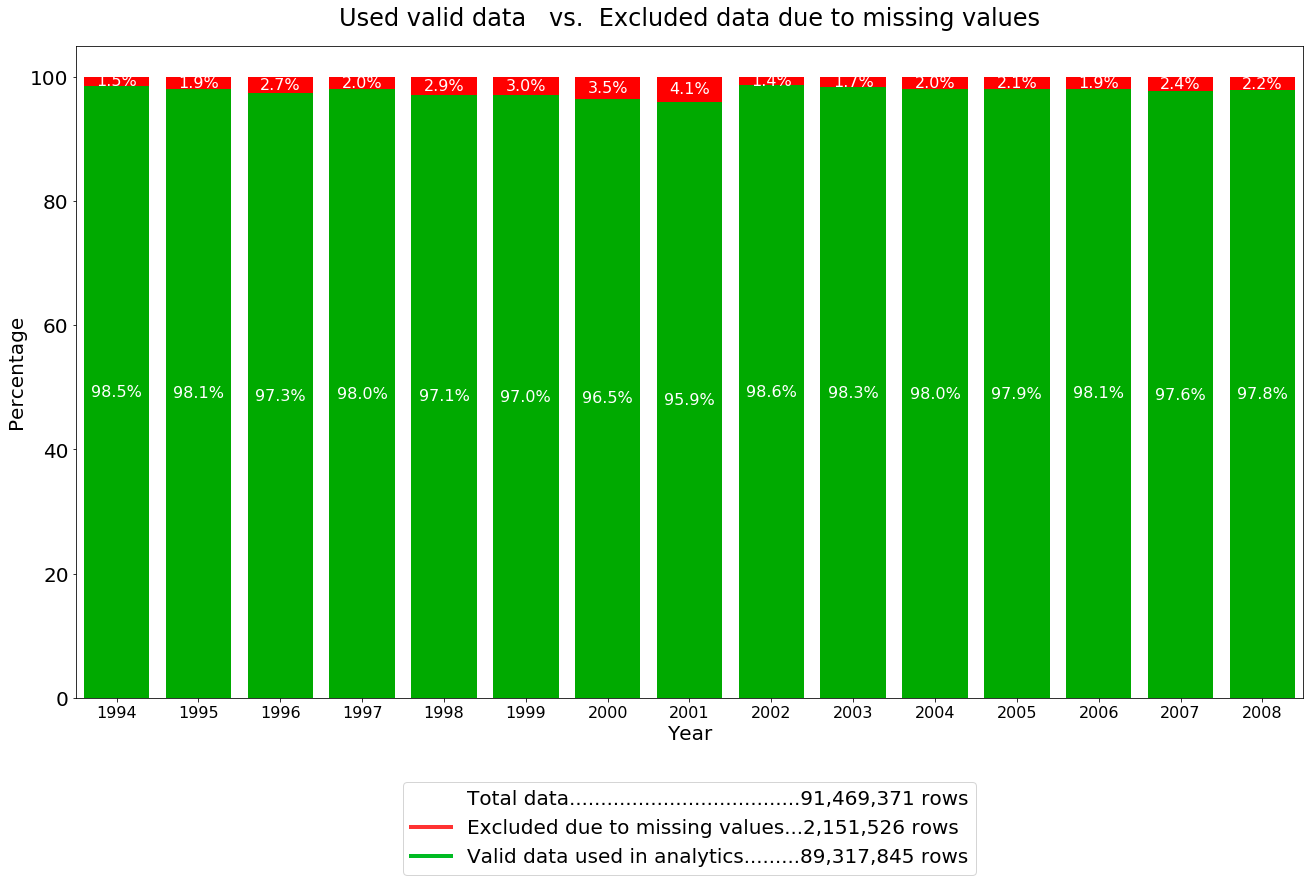

In [25]:
plot_missing_values_stacked_bar(df_missing)

### Airports weekly penalty

A **line plot** is used to display penalties as a time series. On the `x` axis the week number is reported, while on the `y` axis we show the weekly penalty.

Moreover, a **bar plot** is chosen to display the *yearly average* weekly-penalty of a given airport.

In [26]:
display(ui, out)

Output()